In [35]:
import os
import sys

sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))

for p in sys.path:
    print(p)

/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload

/home/jovyan/.local/lib/python3.6/site-packages
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/lib/python3.6/dist-packages
/home/jovyan/.local/lib/python3.6/site-packages/IPython/extensions
/home/jovyan/.ipython
..
..


In [36]:
import yaml

with open("../data/hyp.scratch.tiny.yaml", errors="ignore") as f:
    hyp = yaml.safe_load(f)
hyp

{'lr0': 0.01,
 'lrf': 0.2,
 'momentum': 0.937,
 'weight_decay': 0.0005,
 'warmup_epochs': 3.0,
 'warmup_momentum': 0.8,
 'warmup_bias_lr': 0.1,
 'box': 0.05,
 'lmks_pw': 1.0,
 'lmks': 0.05,
 'cls': 0.5,
 'cls_pw': 1.0,
 'obj': 1.0,
 'obj_pw': 1.0,
 'iou_t': 0.2,
 'anchor_t': 4.0,
 'fl_gamma': 0.0,
 'hsv_h': 0.015,
 'hsv_s': 0.7,
 'hsv_v': 0.4,
 'degrees': 0.0,
 'translate': 0.1,
 'scale': 0.5,
 'shear': 0.5,
 'perspective': 0.0,
 'fliplr': 0.5,
 'mosaic': 0.5,
 'mixup': 0.0,
 'loss_ota': 1}

In [37]:
from utils.datasets import LoadImagesAndLabels

dataset = LoadImagesAndLabels(
    path="/home/jovyan/workspace/datasets/face-detections/widerface/train.txt",
    # path="/home/jovyan/workspace/datasets/face-detections/mtfl/train.txt",
    img_size=640,
    batch_size=2,
    augment=True,
    hyp=hyp,
    rect=False,
    image_weights=False,
    cache_images=True,
    single_cls=False,
    stride=32,
    pad=0,
    prefix="",
)

Scanning '/home/jovyan/workspace/datasets/face-detections/widerface/train' images and labels... 4161 found, 0 missing, 0 empty, 1 corrupted:  32%|███▏      | 4161/12880 [00:01<00:03, 2179.78it/s]

Scanning '/home/jovyan/workspace/datasets/face-detections/widerface/train' images and labels... 7704 found, 0 missing, 0 empty, 2 corrupted:  60%|█████▉    | 7704/12880 [00:03<00:01, 2741.09it/s]

Scanning '/home/jovyan/workspace/datasets/face-detections/widerface/train' images and labels... 11397 found, 0 missing, 0 empty, 3 corrupted:  88%|████████▊ | 11397/12880 [00:04<00:00, 2983.90it/s]

Scanning '/home/jovyan/workspace/datasets/face-detections/widerface/train' images and labels... 12605 found, 0 missing, 0 empty, 4 corrupted:  98%|█████████▊| 12605/12880 [00:04<00:00, 2699.81it/s]

Scanning '/home/jovyan/workspace/datasets/face-detections/widerface/train' images and labels... 12880 found, 0 missing, 0 empty, 4 corrupted: 100%|██████████| 12880/12880 [00:04<00:00, 2651.96it/s]
Caching images (11.1GB): 100%|██████████| 12876/12876 [00:19<00:00, 669.34it/s]


# Utils function

In [38]:
import cv2
import matplotlib.pyplot as plt


def visualize_image(image):
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

In [39]:
import cv2
import matplotlib.pyplot as plt

BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White
LEFT_COLOR = (255, 0, 0)
CENTER_COLOR = (0, 255, 0)
RIGHT_COLOR = (0, 0, 255)


def clip(x, y, width, height, normalized=False):
    if normalized:
        x = x * width
        y = y * height
    x = max(x, 0)
    y = max(y, 0)
    x = min(x, width)
    y = min(y, height)
    x = int(round(x))
    y = int(round(y))
    return x, y


def visualize_bbox(
    img,
    bbox,
    landmark,
    landmark_mask,
    color=BOX_COLOR,
    thickness=2,
    radius=2,
    bbox_type="coco",
    landmark_normalized: bool = True,
):
    r"""Visualizes a single bounding box on the image
    Args:
        bbox: coco
    """

    if bbox_type == "coco":
        x_min, y_min, w, h = bbox
        x_min, x_max, y_min, y_max = (
            int(x_min),
            int(x_min + w),
            int(y_min),
            int(y_min + h),
        )
    elif bbox_type == "pascal_voc":
        x_min, y_min, x_max, y_max = bbox
    elif bbox_type == "albumentations":
        x_min, y_min, x_max, y_max = bbox
        x_min, y_min, x_max, y_max = (
            int(x_min * img.shape[1]),
            int(y_min * img.shape[0]),
            int(x_max * img.shape[1]),
            int(y_max * img.shape[0]),
        )
    elif bbox_type == "yolo":
        cx, cy, w, h = bbox
        x_min, y_min, x_max, y_max = cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2
        x_min, y_min, x_max, y_max = (
            int(x_min * img.shape[1]),
            int(y_min * img.shape[0]),
            int(x_max * img.shape[1]),
            int(y_max * img.shape[0]),
        )
    else:
        raise KeyError("bbox_type error")

    x_min, y_min, x_max, y_max = (
        int(round(x_min)),
        int(round(y_min)),
        int(round(x_max)),
        int(round(y_max)),
    )

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    if landmark is not None and landmark_mask is not None:
        if landmark_mask[0] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[0],
                    landmark[1],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=LEFT_COLOR,
                thickness=-1,
            )
        if landmark_mask[1] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[2],
                    landmark[3],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=RIGHT_COLOR,
                thickness=-1,
            )
        if landmark_mask[2] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[4],
                    landmark[5],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=CENTER_COLOR,
                thickness=-1,
            )
        if landmark_mask[3] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[6],
                    landmark[7],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=LEFT_COLOR,
                thickness=-1,
            )
        if landmark_mask[4] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[8],
                    landmark[9],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=RIGHT_COLOR,
                thickness=-1,
            )

    return img


def visualize(
    image,
    bboxes,
    landmarks,
    landmarks_mask,
    bbox_type="coco",
    thickness=2,
    radius=2,
    landmark_normalized: bool = True,
):
    img = image.copy()
    for bbox, landmark, landmark_mask in zip(bboxes, landmarks, landmarks_mask):
        img = visualize_bbox(
            img,
            bbox,
            landmark,
            landmark_mask,
            bbox_type=bbox_type,
            thickness=thickness,
            radius=radius,
            landmark_normalized=landmark_normalized,
        )
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img)
    plt.show()

In [40]:
def check_landmask(landmasks, landmasks_mask, width, height):
    for landmark, landmark_mask in zip(landmasks, landmasks_mask):
        for i in range(5):
            if landmark_mask[i] > 0:
                assert landmark[2 * i] > 0 and landmark[2 * i] < width, f"{landmark}, {landmark_mask}"
                assert landmark[2 * i + 1] > 0 and landmark[2 * i + 1] < height, f"{landmark}, {landmark_mask}"

# Test dataset

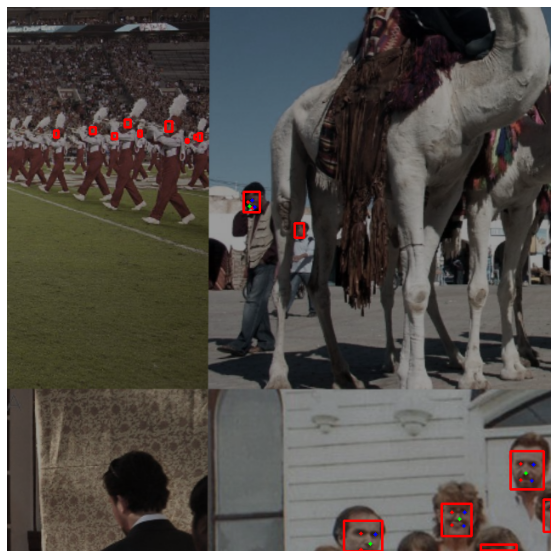

In [41]:
import random

import numpy as np

for _ in range(100):
    index = random.randint(0, len(dataset.indices))

    img, labels, paths, shape = dataset[index]

    check_landmask(labels[:, 6:16], labels[:, 16:21], img.shape[1], img.shape[0])

visualize(
    np.clip(img.numpy(), 0, 255).astype(np.uint8).transpose(1, 2, 0),
    labels[:, 2:6].numpy(),
    labels[:, 6:16].numpy(),
    labels[:, 16:21].numpy(),
    "yolo",
    landmark_normalized=True,
)

# Test dataloader

In [42]:
img1, label1, path1, shape1 = dataset[random.randint(0, len(dataset.indices))]
img2, label2, path2, shape2 = dataset[random.randint(0, len(dataset.indices))]
img3, label3, path3, shape3 = dataset[random.randint(0, len(dataset.indices))]
img4, label4, path4, shape4 = dataset[random.randint(0, len(dataset.indices))]

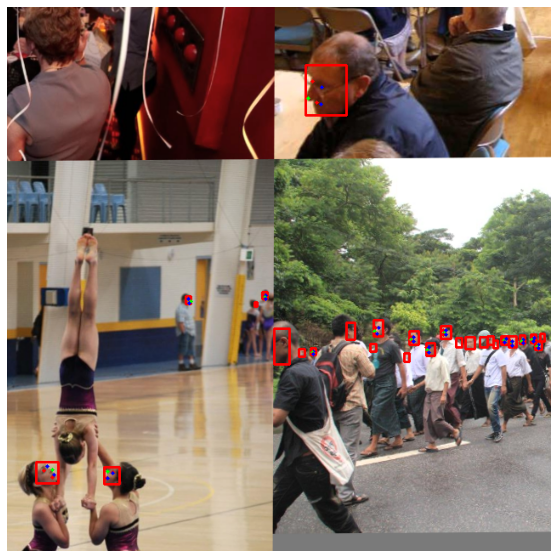

In [43]:
%matplotlib inline

import numpy as np

visualize(
    np.clip(img1.numpy(), 0, 255).astype(np.uint8).transpose(1, 2, 0),
    label1[:, 2:6].numpy(),
    label1[:, 6:16].numpy(),
    label1[:, 16:21].numpy(),
    "yolo",
    landmark_normalized=True,
)

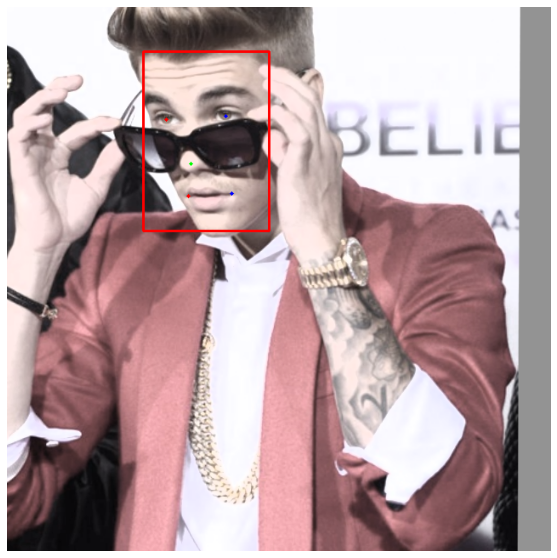

In [44]:
%matplotlib inline

import numpy as np

visualize(
    np.clip(img2.numpy(), 0, 255).astype(np.uint8).transpose(1, 2, 0),
    label2[:, 2:6].numpy(),
    label2[:, 6:16].numpy(),
    label2[:, 16:21].numpy(),
    "yolo",
    landmark_normalized=True,
)

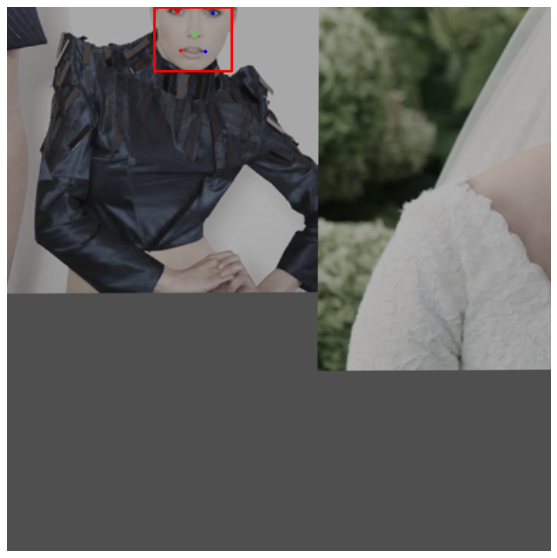

In [45]:
%matplotlib inline

import numpy as np

visualize(
    np.clip(img3.numpy(), 0, 255).astype(np.uint8).transpose(1, 2, 0),
    label3[:, 2:6].numpy(),
    label3[:, 6:16].numpy(),
    label3[:, 16:21].numpy(),
    "yolo",
    landmark_normalized=True,
)

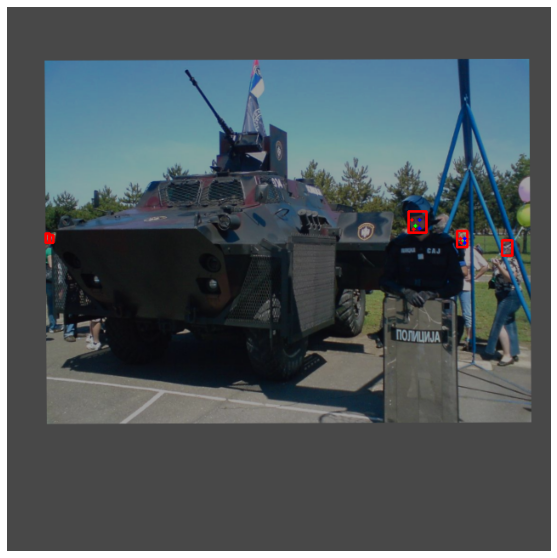

(tensor([[0.74432, 0.39092, 0.75824, 0.39037, 0.75036, 0.40208, 0.74617, 0.40831, 0.75834, 0.40702],
         [0.83252, 0.42571, 0.84054, 0.42549, 0.83628, 0.43054, 0.83387, 0.43316, 0.84040, 0.43276],
         [0.06822, 0.09747, 0.06822, 0.09747, 0.06822, 0.09747, 0.06822, 0.09747, 0.06822, 0.09747],
         [0.06822, 0.09747, 0.06822, 0.09747, 0.06822, 0.09747, 0.06822, 0.09747, 0.06822, 0.09747],
         [0.06822, 0.09747, 0.06822, 0.09747, 0.06822, 0.09747, 0.06822, 0.09747, 0.06822, 0.09747]]),
 tensor([[ 1.,  1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]))

In [46]:
%matplotlib inline

import numpy as np

visualize(
    np.clip(img4.numpy(), 0, 255).astype(np.uint8).transpose(1, 2, 0),
    label4[:, 2:6].numpy(),
    label4[:, 6:16].numpy(),
    label4[:, 16:21].numpy(),
    "yolo",
    landmark_normalized=True,
)
label4[:, 6:16], label4[:, 16:21]

In [47]:
import random

imgs, labels, paths, shapes = dataset.collate_fn(
    (
        (img1, label1, path1, shape1),
        (img2, label2, path2, shape2),
        (img3, label3, path3, shape3),
        (img4, label4, path4, shape4),
    )
)

In [48]:
from utils.plots import plot_images

# TODO: Not working
a = plot_images(imgs, labels, lmks_radius=5)

# Without mosaic

## Load image

In [49]:
import random

from utils.datasets import load_image

for _ in range(100):
    index = random.randint(0, len(dataset.indices))

    img, (h0, w0), (h, w) = load_image(dataset, index)

    labels = dataset.labels[index].copy()

    check_landmask(labels[:, 5:15], labels[:, 15:20], 640, 640)

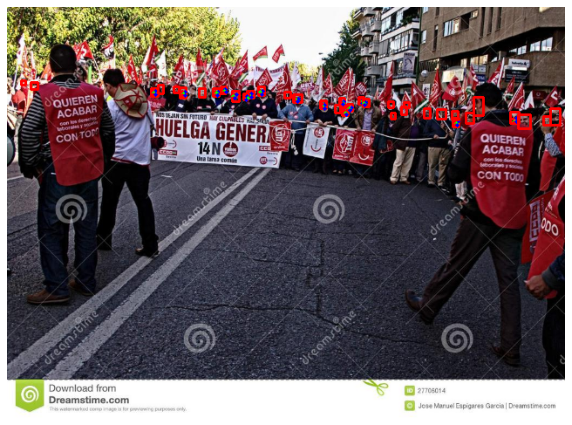

In [50]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15:20],
    "yolo",
    landmark_normalized=True,
)

## Letterbox

In [51]:
import random

from utils.datasets import load_image

index = random.randint(0, len(dataset.indices))

img, (h0, w0), (h, w) = load_image(dataset, index)

labels = dataset.labels[index].copy()

In [52]:
# Letterbox
shape = (
    dataset.batch_shapes[dataset.batch[index]] if dataset.rect else dataset.img_size
)  # final letterboxed shape
shape

640

In [53]:
from utils.datasets import letterbox

img, ratio, pad = letterbox(img, shape, auto=False, scaleup=dataset.augment)
img.shape, ratio, pad

((640, 640, 3), (1.0, 1.0), (0.0, 80.0))

In [54]:
from utils.general import xywhn2xyxy

if labels.size:  # normalized xywh to pixel xyxy format
    labels[:, 1:5] = xywhn2xyxy(
        labels[:, 1:5], ratio[0] * w, ratio[1] * h, padw=pad[0], padh=pad[1]
    )
    # Landmark x
    labels[:, 5:15:2] = (ratio[0] * w) * labels[:, 5:15:2] + pad[0]
    # Landmark y
    labels[:, 6:15:2] = (ratio[1] * h) * labels[:, 6:15:2] + pad[1]

In [55]:
shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling
# labels = dataset.labels[index].copy()

In [56]:
check_landmask(labels[:, 5:15], labels[:, 15:20], 640, 640)

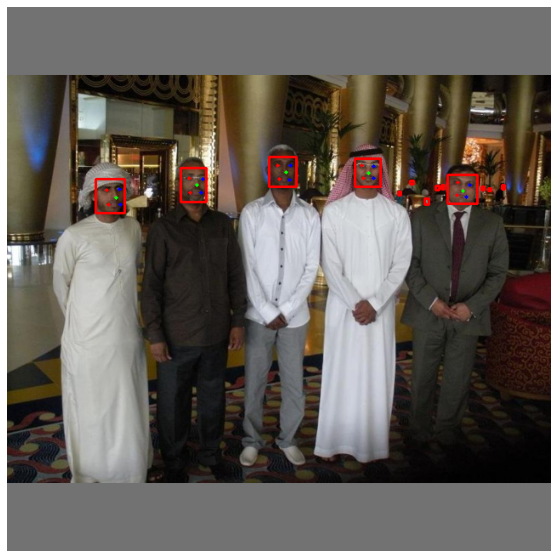

In [57]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15:20],
    "pascal_voc",
    landmark_normalized=False,
)

## Random perspective

In [58]:
import random

from utils.datasets import load_image, random_perspective

for _ in range(1000):
    index = random.randint(0, len(dataset.indices))

    img, (h0, w0), (h, w) = load_image(dataset, index)

    labels = dataset.labels[index].copy()

    # Letterbox
    shape = (
        dataset.batch_shapes[dataset.batch[index]] if dataset.rect else dataset.img_size
    )  # final letterboxed shape

    from utils.datasets import letterbox

    img, ratio, pad = letterbox(img, shape, auto=False, scaleup=dataset.augment)

    from utils.general import xywhn2xyxy

    if labels.size:  # normalized xywh to pixel xyxy format
        labels[:, 1:5] = xywhn2xyxy(
            labels[:, 1:5], ratio[0] * w, ratio[1] * h, padw=pad[0], padh=pad[1]
        )
        # Landmark x
        labels[:, 5:15:2] = (ratio[0] * w) * labels[:, 5:15:2] + pad[0]
        # Landmark y
        labels[:, 6:15:2] = (ratio[1] * h) * labels[:, 6:15:2] + pad[1]

    shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling
    # labels = dataset.labels[index].copy()

    img, labels = random_perspective(
        img,
        labels,
        degrees=hyp["degrees"],
        translate=hyp["translate"],
        scale=hyp["scale"],
        shear=hyp["shear"],
        perspective=hyp["perspective"],
    )

    check_landmask(labels[:, 5:15], labels[:, 15:20], img.shape[1], img.shape[0])

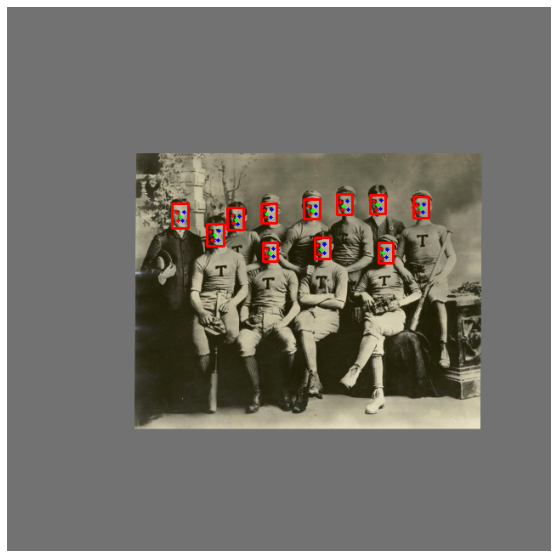

In [59]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15:20],
    "pascal_voc",
    landmark_normalized=False,
)

## Normalize x y

In [60]:
from utils.general import xyxy2xywh

nL = len(labels)  # number of labels
if nL:
    labels[:, 1:5] = xyxy2xywh(labels[:, 1:5])  # convert xyxy to xywh
    labels[:, [2, 4]] /= img.shape[0]  # normalized height 0-1
    labels[:, [1, 3]] /= img.shape[1]  # normalized width 0-1

    # Landmark x
    labels[:, 5:15:2] /= img.shape[1]
    # Landmark y
    labels[:, 6:15:2] /= img.shape[0]

## Flip left right

In [61]:
import numpy as np

img = np.fliplr(img)
labels[:, 1] = 1 - labels[:, 1]
labels[:, 5:15:2] = 1 - labels[:, 5:15:2]
labels[:, [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]] = labels[
    :, [7, 8, 5, 6, 9, 10, 13, 14, 11, 12]
]

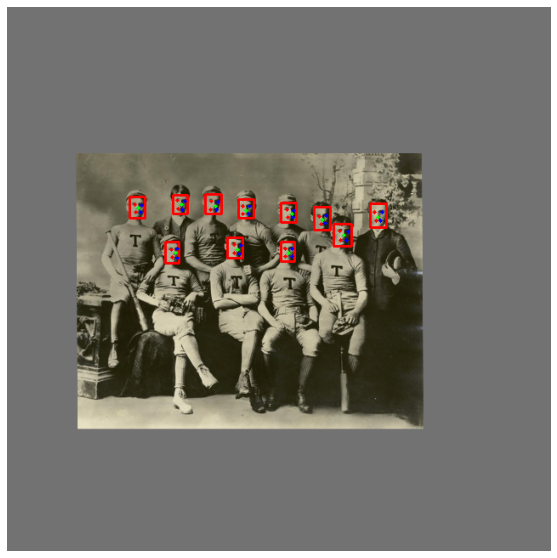

In [62]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15:20],
    "yolo",
    landmark_normalized=True,
)

# With mosaic

## load_mosaic

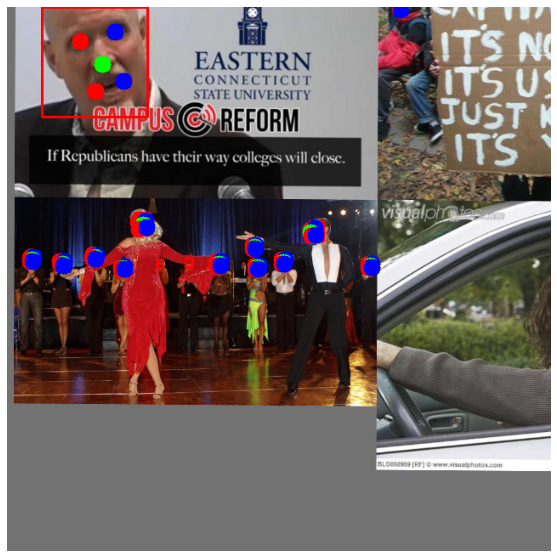

In [63]:
import random

from utils.datasets import load_mosaic

for _ in range(1000):
    index = random.randint(0, len(dataset.indices))

    img, labels = load_mosaic(dataset, index)

    check_landmask(labels[:, 5:15], labels[:, 15:20], img.shape[1], img.shape[0])

visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15:20],
    "pascal_voc",
    landmark_normalized=False,
    radius=10,
)

## load_mosaic9

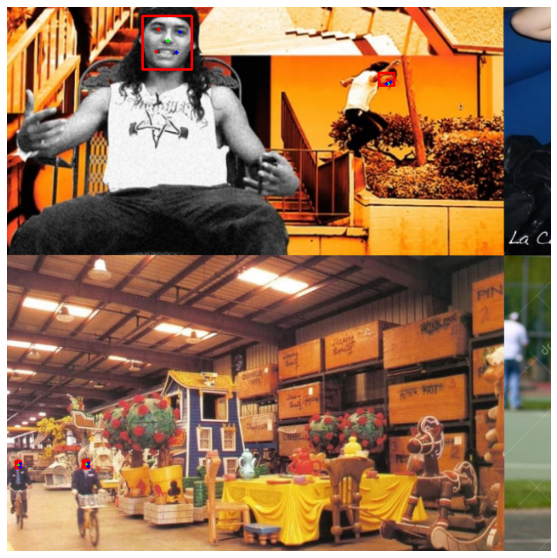

In [64]:
import random

from utils.datasets import load_mosaic9

for _ in range(1000):
    index = random.randint(0, len(dataset.indices))

    img, labels = load_mosaic9(dataset, index)

    check_landmask(labels[:, 5:15], labels[:, 15:20], img.shape[1], img.shape[0])

visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15:20],
    "pascal_voc",
    landmark_normalized=False,
)

# With mixup

In [65]:
import random

from utils.datasets import load_mosaic, load_mosaic9

for _ in range(1000):
    index = random.randint(0, len(dataset.indices))

    if random.random() < 0.8:
        img, labels = load_mosaic(dataset, index)
    else:
        img, labels = load_mosaic9(dataset, index)

    import numpy as np

    if random.random() < 0.8:
        img2, labels2 = load_mosaic(dataset, random.randint(0, len(dataset.labels) - 1))
    else:
        img2, labels2 = load_mosaic9(
            dataset, random.randint(0, len(dataset.labels) - 1)
        )
    r = np.random.beta(8.0, 8.0)  # mixup ratio, alpha=beta=8.0
    img = (img * r + img2 * (1 - r)).astype(np.uint8)
    labels = np.concatenate((labels, labels2), 0)

    check_landmask(labels[:, 5:15], labels[:, 15:20], img.shape[1], img.shape[0])

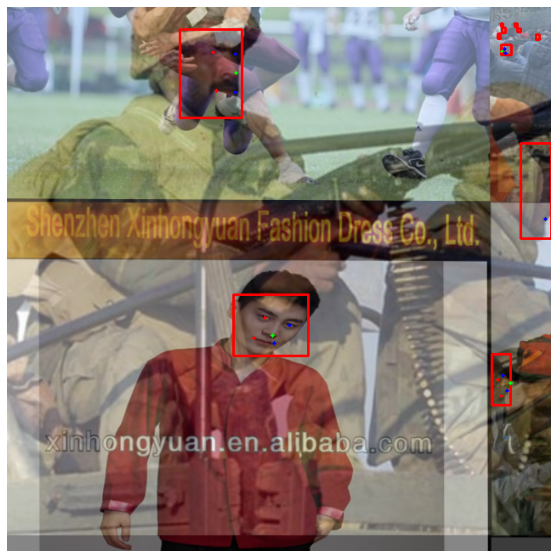

In [66]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15:20],
    "pascal_voc",
    landmark_normalized=False,
)